In [1]:
import pyzed.sl as sl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

svo_path = '../data/HD1080_SN35520970_11-03-24.svo'
zed = sl.Camera()

In [2]:

# init parameters
init_params = sl.InitParameters()
init_params.set_from_svo_file(svo_path)
init_params.depth_mode = sl.DEPTH_MODE.ULTRA
init_params.coordinate_units = sl.UNIT.METER
init_params.depth_maximum_distance = 40
init_params.depth_minimum_distance = 1
init_params.sdk_verbose = True

res = sl.Resolution()
res.width = 1920
res.height = 1080


In [3]:

zed.open(init_params)
calibration_frames = 50
skip_frames = 30
runtime_parameters = sl.RuntimeParameters()
temp_image_left = sl.Mat()
temp_image_right = sl.Mat()
temp_image_depth_left = sl.Mat()
color_array_l = np.zeros((1080, 1920, 3, calibration_frames))
color_array_r = np.zeros((1080, 1920, 3, calibration_frames))
depth_array_l = np.zeros((1080, 1920, calibration_frames))

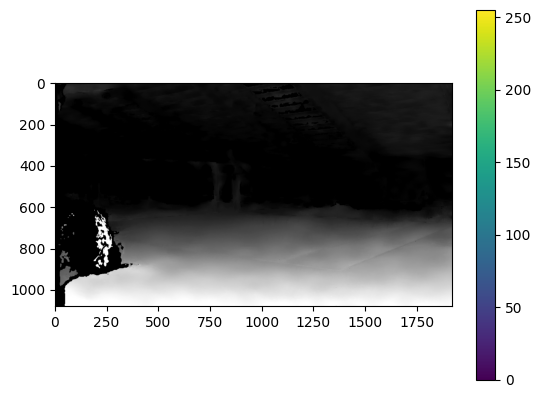

In [4]:
zed.grab(runtime_parameters)
zed.retrieve_image(temp_image_depth_left, sl.VIEW.DEPTH)


plt.imshow(temp_image_depth_left.get_data()[:,:,:])
plt.colorbar()
plt.show()


In [5]:
for i in tqdm(range(calibration_frames * skip_frames)):
    zed.grab(runtime_parameters)
    if i % skip_frames != 0:
        continue
    # zed.retrieve_measure(image, sl.MEASURE.DEPTH)
    zed.retrieve_image(temp_image_left, sl.VIEW.LEFT)
    current_frame_l = temp_image_left.get_data()[:, :, :3]
    color_array_l[:, :, :, i // skip_frames] = current_frame_l
    zed.retrieve_image(temp_image_depth_left, sl.VIEW.DEPTH)
    current_frame_depth_l = temp_image_depth_left.get_data()[:,:,:]
    depth_array_l[:,:,:,i // skip_frames] = current_frame_depth_l
    

100%|██████████| 1500/1500 [00:53<00:00, 28.23it/s]


In [6]:
background_l = np.nanmedian(color_array_l, axis=3)
depth_background_l = np.nanmedian(depth_array_l, axis=3)


(1080, 1920, 3)


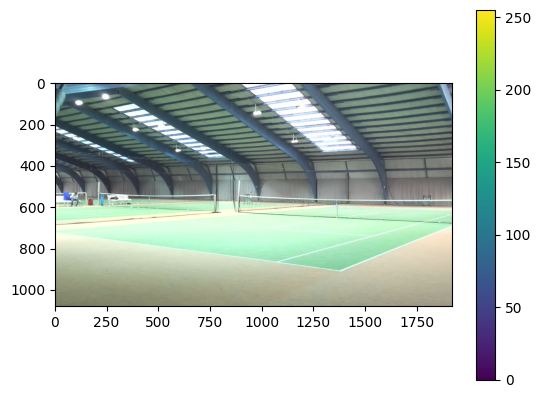

In [7]:
print(background_l.shape)
plt.imshow(background_l.astype(np.uint8))
plt.colorbar()
plt.show()

(1080, 1920, 4)


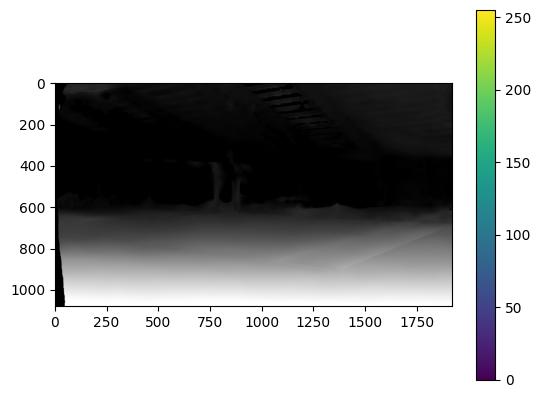

In [8]:
print(depth_background_l.shape)
plt.imshow(depth_background_l.astype(np.uint8))
plt.colorbar()
plt.show()

In [5]:
image_test = sl.Mat()
zed.set_svo_position(2182)
zed.grab(runtime_parameters)
zed.retrieve_image(image_test, sl.VIEW.LEFT)
current_frame_l = image_test.get_data()[:, :, :3]

In [21]:
import numpy as np

def find_yellow_areas(image):
    
    ### ACHTUNG: Die Matrix der ZED-Library gibt BGR-Bilder aus und keine RGB. [BlauMin, GrünMin, RotMin), (BlauMax, GrünMax, RotMax)] ###
    # Definieren der Gelbschwelle
    yellow_threshold = [(0, 180, 180), (200, 255, 255)]  # Min und Max für Gelb

    binary_matrix = np.zeros((image.shape[0], image.shape[1]))

    # Finden der Pixel, die innerhalb des Gelb-Bereichs liegen
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            #Pixel[0] = Blau, Pixel[1] = Grün, Pixel[2] = Rot
            pixel = image[i, j, :]
            if (pixel[0] > yellow_threshold[0][0] and pixel[0] < yellow_threshold[1][0]) and \
               (pixel[1] > yellow_threshold[0][1] and pixel[1] < yellow_threshold[1][1]) and \
               (pixel[2] > yellow_threshold[0][2] and pixel[2] < yellow_threshold[1][2]):
                binary_matrix[i, j] = 1

    return binary_matrix


In [22]:
yellow_pixels = find_yellow_areas(current_frame_l)

In [23]:
newYellowImg = current_frame_l.copy()
newYellowImg[:,:,0] = newYellowImg[:,:,0] * yellow_pixels
newYellowImg[:,:,1] = newYellowImg[:,:,1] * yellow_pixels
newYellowImg[:,:,2] = newYellowImg[:,:,2] * yellow_pixels
newYellowImg = newYellowImg.astype(np.uint8)

In [24]:
def convert_BGR_to_RGB(image):
    imageBlue = image[:,:, 0]
    imageGreen = image[:,:, 1]
    imageRed = image[:,:, 2]
    newRGBImage = np.zeros_like(image)
    newRGBImage[:,:,0] = imageRed
    newRGBImage[:,:,1] = imageGreen
    newRGBImage[:,:,2] = imageBlue
    
    newRGBImage = newRGBImage.astype(np.uint8)
    return newRGBImage

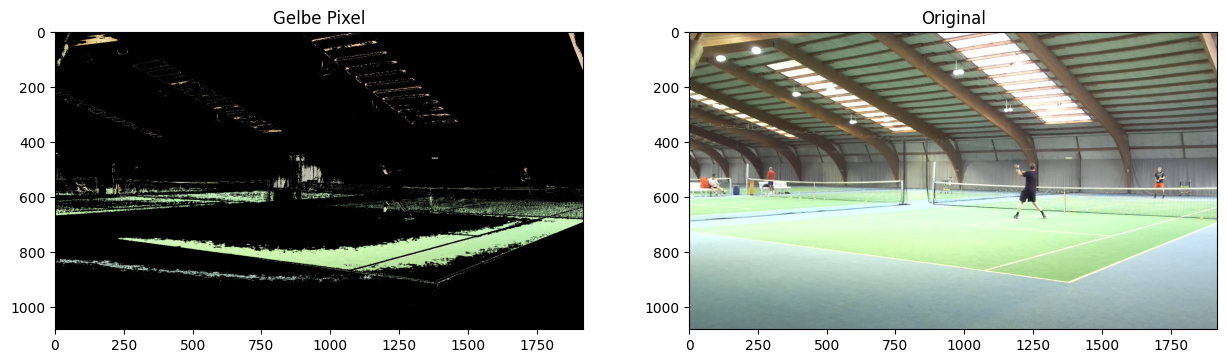

In [25]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(convert_BGR_to_RGB(newYellowImg))
plt.title('Gelbe Pixel')


plt.subplot(1, 2, 2)
plt.imshow(convert_BGR_to_RGB(current_frame_l))
plt.title('Original')
plt.show()


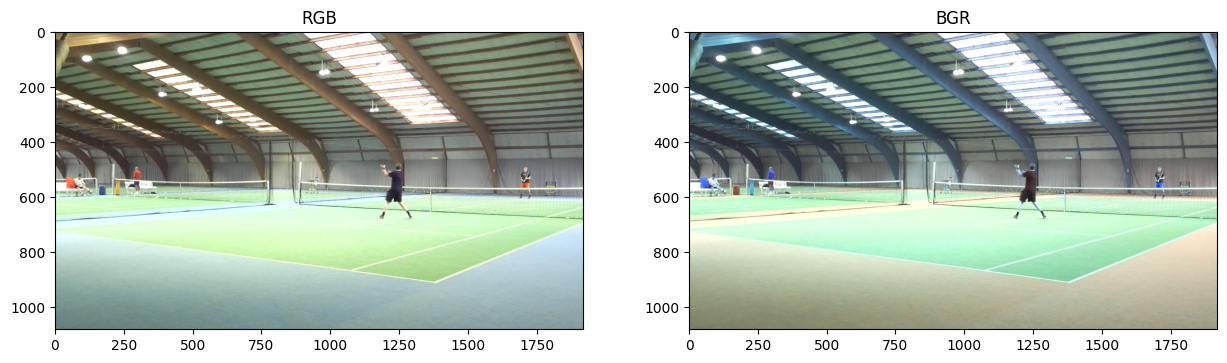

In [14]:
imageBlue = current_frame_l[:,:, 0]
imageGreen = current_frame_l[:,:, 1]
imageRed = current_frame_l[:,:, 2]
newRGBImage = np.zeros_like(current_frame_l)
newRGBImage[:,:,0] = imageRed
newRGBImage[:,:,1] = imageGreen
newRGBImage[:,:,2] = imageBlue

newRGBImage = newRGBImage.astype(np.uint8)
oldBGRImage = current_frame_l.astype(np.uint8)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(newRGBImage)
plt.title('RGB')


plt.subplot(1, 2, 2)
plt.imshow(oldBGRImage)
plt.title('BGR')
plt.show()



In [56]:
# Aufteilen in RGB-Komponenten
def farben(image):
    red = image[:, :, 2]
    green = image[:, :, 1]
    blue = image[:, :, 1]
    
    # Anzeigen der einzelnen Farbkomponenten
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(red, cmap='Reds')
    plt.title('Roter Kanal')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(green, cmap='Greens')
    plt.title('Grüner Kanal')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(blue, cmap='Blues')
    plt.title('Blauer Kanal')
    plt.axis('off')
    
    plt.show()

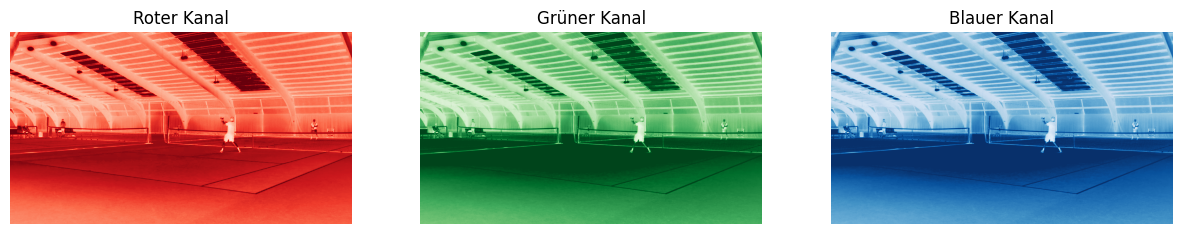

In [57]:
farben(current_frame_l)

In [53]:
image_test.get_channels()

4

In [9]:
zed.close()